#### **Imports**

In [25]:
## import essential modules 
import qumcmc 
from qumcmc.energy_models import IsingEnergyFunction
from qumcmc.classical_mcmc_routines import *
from qumcmc.quantum_mcmc_routines import *
from qumcmc.basic_utils import *
from qumcmc.trajectory_processing import *

#### **Define the Energy Model**

In [9]:
# define the model
np.random.seed(612358)# should always be in the same cell!  
n_spins = 15

## construct problem Hamiltonian ##
shape_of_J=(n_spins,n_spins)

## defining J matrix (mutual 1-1 interaction)
# J =  np.round(np.random.choice([+1, 0, -1], size=(n_spins, n_spins)), decimals=2) 
J =  np.random.uniform(low= -1, high= 1, size= (n_spins, n_spins) )

J = 0.5 * (J + J.transpose() )
J = np.round( J - np.diag(np.diag(J)) , decimals= 3)

# defining h
h = np.round(np.random.randn(n_spins), decimals=2)#np.random.uniform(low= -1, high = 1, size= (n_spins))

# instantiate the model
model = IsingEnergyFunction(J, h, name= 'my_model')


            MODEL : my_model
Non-zero Interactions (J) :  210
Non-zero Bias (h) :  15
---------------------------------------------
Average Interaction Strength <J> :  0.02907555555555556
Average Bias Strength <h>:  0.12066666666666669
alpha :  0.5800327886103367
model beta :  1.0
---------------------------------------------


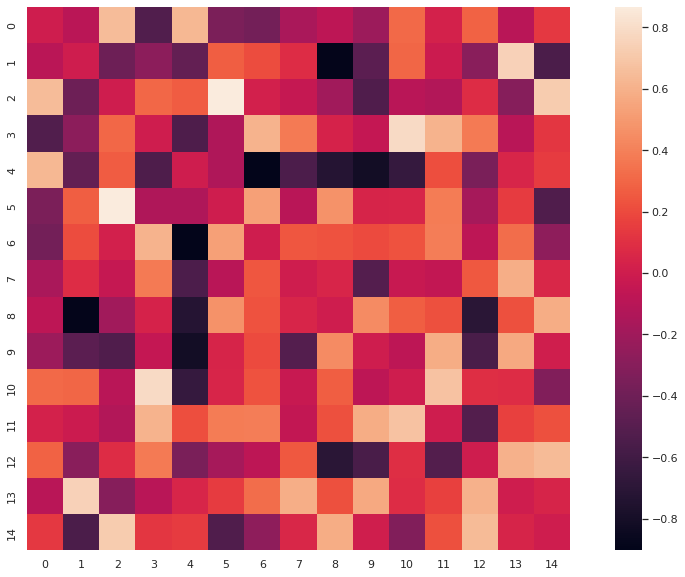

In [10]:
model.model_summary()

#### **Exact Analysis**

In [11]:
## set current beta
beta = 1.100209

## run exact sampling over all possible configurations 
model.run_exact_sampling(beta)

Running Exact Sampling | Model beta :  1.100209


running over all possible configurations: 100%|██████████| 32768/32768 [00:00<00:00, 45874.96it/s]

saving distribution to model ...


In [12]:
model.exact_sampling_status

True

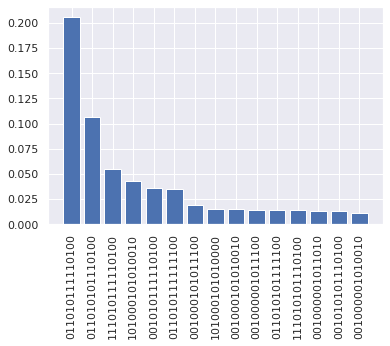

In [13]:
## get the distribution from model
bpd = model.boltzmann_pd

## plot the distribution
plot_bargraph_desc_order(bpd, label= 'Boltzmann Dist.', plot_first_few= 15)

#### **Run Classical MCMC**

In [23]:
steps = 5000
config_counts_c, proposed_states_c, accepted_states_c =classical_mcmc(
    N_hops=steps,
    model=model,
    return_last_n_states=10,
    return_additional_lists=True,
    temp=1/beta,
)

starting with:  100110011010101


running MCMC steps ...: 100%|██████████| 5000/5000 [00:00<00:00, 14911.55it/s]


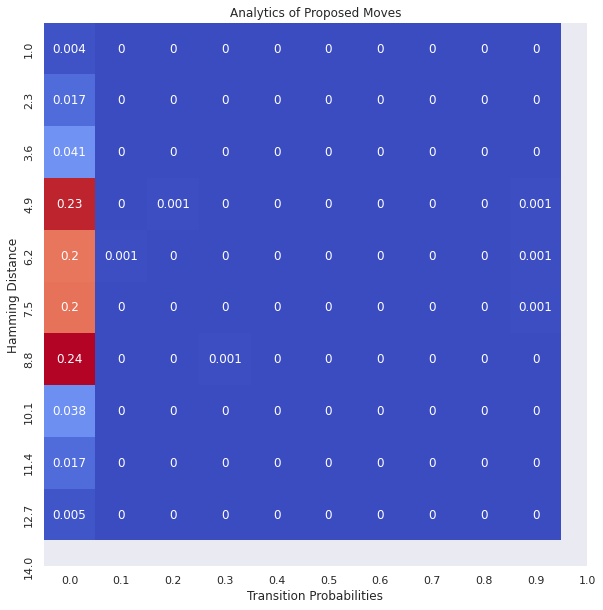

In [24]:
energy_diff = []; hamming_diff= []; transition_probs= []
proposed_states = proposed_states_c
accepted_states = accepted_states_c

for s in range(len(accepted_states)-1):
    hamming_diff.append(hamming_dist(proposed_states[s+1], accepted_states[s]))
    transition_probs.append( min(1, model.get_boltzmann_prob(proposed_states[s+1]) / model.get_boltzmann_prob(accepted_states[s])) )

# plt.scatter(transition_probs, hamming_diff)

fills, xticks, yticks = np.histogram2d(transition_probs, hamming_diff, density= True)
fills = fills / np.sum(fills)
plt.figure(figsize=(10,10))
sns.heatmap(np.round(fills.transpose(), decimals=3), square= True, xticklabels= np.round( xticks, decimals= 1) , yticklabels= np.round( yticks, decimals= 1), cmap="coolwarm", cbar= False, annot= True)
plt.xlabel("Transition Probabilities")
plt.ylabel("Hamming Distance")
plt.title("Analytics of Proposed Moves : Uniform")
plt.show()

#### **Run Quantum Enhaned MCMC**

In [21]:
steps = 5000
config_counts_q, proposed_states_q, accepted_states_q =quantum_enhanced_mcmc(
    N_hops=steps,
    model=model,
    return_last_n_states=10,
    return_additional_lists=True,
    temp=1/beta,
)

trajectory_q = trajectory_processing(accepted_states_q)

starting with:  011100001111110


runnning quantum MCMC steps . ..: 100%|██████████| 5000/5000 [26:19<00:00,  3.17it/s]


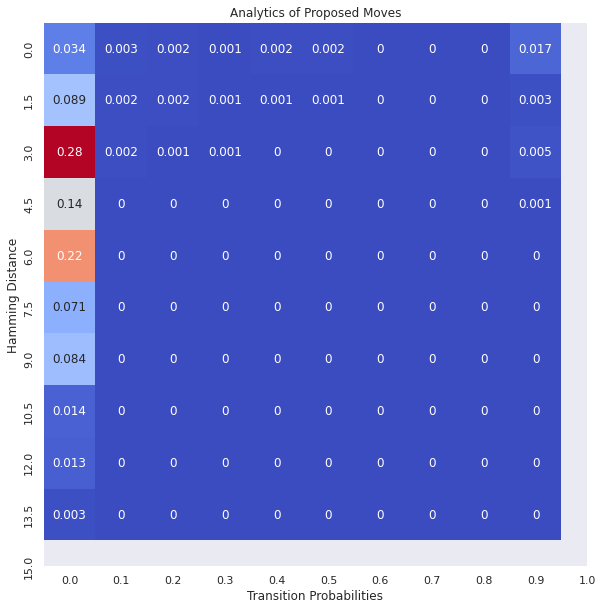

In [22]:
energy_diff = []; hamming_diff= []; transition_probs= []
proposed_states = proposed_states_q
accepted_states = accepted_states_q

for s in range(len(accepted_states)-1):
    hamming_diff.append(hamming_dist(proposed_states[s+1], accepted_states[s]))
    transition_probs.append( min(1, model.get_boltzmann_prob(proposed_states[s+1]) / model.get_boltzmann_prob(accepted_states[s])) )

# plt.scatter(transition_probs, hamming_diff)

fills, xticks, yticks = np.histogram2d(transition_probs, hamming_diff, density= True)
fills = fills / np.sum(fills)
plt.figure(figsize=(10,10))
sns.heatmap(np.round(fills.transpose(), decimals=3), square= True, xticklabels= np.round( xticks, decimals= 1) , yticklabels= np.round( yticks, decimals= 1), cmap="coolwarm", cbar= False, annot= True)
plt.xlabel("Transition Probabilities")
plt.ylabel("Hamming Distance")
plt.title("Analytics of Proposed Moves : Quantum Enhanced ")
plt.show()

#### **Convergence Analysis**

##### Magnetisation

##### JS Divergence